# HW Project2

## A: Web Scraping

### Dynamically check all available years of alumnis

In [31]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
url = "https://www.mccormick.northwestern.edu/machine-learning-data-science/people/alumni/"
# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find all <a> elements with class "link-arrows" and extract the href attributes
hrefs = soup.find_all('a', class_='link-arrows')

# Extract 4-digit years from href attributes using regular expressions and store them in a sorted list without duplicates
avail_years = sorted(set(int(re.search(r'\b\d{4}\b', href['href']).group()) for href in hrefs if re.search(r'\b\d{4}\b', href['href'])))

# Print the sorted list of 4-digit numbers
print(avail_years)

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


### Scrape all students from all available years and store them in a df. For missing Information insert "missing"

In [32]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup

# Initialize an empty list to store the DataFrames for each year
dfs = []

# Loop through the years from 2013 to 2022
# for year in range(2013, 2023):
for year in avail_years:
    # Construct the URL for the specific year
    url = f"https://www.mccormick.northwestern.edu/machine-learning-data-science/people/alumni/class-of-{year}.html"
    
    # Make the request to the URL
    response = requests.get(url)

    # Parse the response text as a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract 'student-alumni-details' text or set to 'missing at missing' if not found
    faculty_divs = soup.find_all('div', class_='faculty cf')
    text_contents = []
    for faculty_div in faculty_divs:
        student_alumni_details = faculty_div.find('div', class_='student-alumni-details')
        if student_alumni_details:
            text_contents.append(student_alumni_details.text)
        else:
            text_contents.append("missing at missing")

    # Create DataFrame from the extracted text contents
    df = pd.DataFrame(text_contents, columns=["Title_Comp"])

    # Clean the 'Title_Comp' column by replacing special characters
    df['Title_Comp'] = df['Title_Comp'].str.replace('\xa0', ' ', regex=True)

    # Split 'Title_Comp' into 'Title' and 'Company' columns
    def custom_split(row):
        if ' at ' in row:
            return row.split(' at ', 1)
        else:
            return [row, None]

    df[['Title', 'Company']] = df['Title_Comp'].apply(lambda x: pd.Series(custom_split(x)))

    df['Company'].fillna('missing', inplace=True)

    # Drop the original 'Title_Comp' column if no longer needed
    df.drop(columns=['Title_Comp'], inplace=True)

    # Extract graduation year from the page title
    grad_year = soup.find('h1', id="page-title").text
    grad_year_cleaned = re.search(r'\b\d{4}\b', grad_year)
    grad_year_cleaned = int(grad_year_cleaned.group()) if grad_year_cleaned else None

    # Create a DataFrame with the extracted graduation year
    df2 = pd.DataFrame({'grad_year': [grad_year_cleaned]})

    # Extract 'student_names' from <h3> elements inside <div> with class "faculty-info"
    student_names = soup.select('div.faculty-info h3')
    student_names_text = [h3_element.text for h3_element in student_names]
    df3 = pd.DataFrame(student_names_text, columns=["student_names"])

    # Perform a cross join between df3 and result DataFrames
    result = pd.merge(df, df2, how='cross')
    df_result = pd.concat([df3, result], axis=1)
    
    # Store the DataFrame for the current year in the list
    dfs.append(df_result)

# Concatenate all DataFrames vertically to create the final DataFrame
final_df = pd.concat(dfs, ignore_index=True)

# Print the final DataFrame containing data from 2013 to 2022
final_df

,student_names,Title,Company,grad_year
0,Scott Albrecht,"Senior Manager, Data Science",Grainger,2013
1,Yoojong Bang,Principal Data Scientist,Intent Media Inc.,2013
2,Shawna Baskin,Senior Manager - Tabletop Analytics,Wizards of the Coast,2013
3,William Chiu,"Vice President, Head of Statistical Modeling",First Republic Bank,2013
4,David Cooperberg,Senior Product Manager,Alteryx,2013
...,...,...,...,...
382,Qingyang (Jojo) Zhou,missing,missing,2022
383,Shenglang (Dylan) Zhou,Machine Learning Engineer,Pinterest,2022
384,Yihan Zhou,Applied AI/ML Senior Associate,J.P. Morgan Chase,2022
385,Shuli (Sheryl) Zhu,missing,missing,2022


## Dealing with Special Cases that don't follow schema:

In [33]:
# Identifying Students, where job description does not follow pattern - Manual Cleaning required.
filtered_rows1 = final_df[(final_df['Company'] == 'missing') & (final_df['Title'] != 'missing')]
filtered_rows1

,student_names,Title,Company,grad_year
13,Isaac Lo,Big Data Student in the Bay Area,missing,2013
87,James Tarlow,Data Science - Product and Practice Development,missing,2015
302,Luping (Rachel) Zhao,Data Scientist TikTok,missing,2020
316,Sara Ho,Data Engineer Rad AI,missing,2021


In [34]:
#Manually cleaning those special cases:
final_df.loc[final_df['student_names'] == 'Luping (Rachel) Zhao', 'Company'] = 'TikTok'
final_df.loc[final_df['student_names'] == 'Sara Ho', 'Company'] = 'Rad AI'

final_df.loc[final_df['student_names'] == 'Luping (Rachel) Zhao', 'Title'] = 'Data Scientist'
final_df.loc[final_df['student_names'] == 'Sara Ho', 'Title'] = 'Data Engineer'
# No need to change the other two, because they don't have a correct job listed

In [35]:
# Identifying Students with multiple positions - Manual Cleaning required.
# Use regex to filter rows where 'A' contains " at "
filtered_rows2 = final_df[final_df['Company'].str.contains(r' at ', case=False, na=False)]
filtered_rows2

,student_names,Title,Company,grad_year
10,Eunhee Emily Ko,Assitant Professor,Northwestern University and Research Assitant ...,2013
32,Swap Chhabra,Computational Research Scientist - ML in Heatlh,J Clinic & BE at Massachusetts Institute of Te...,2014
72,Alejandro Herrera,Founding Partner,Aventrix and Solution Leader at C3.ai,2015
117,Terrence Neumann,PhD Student (studying Information Systems),the Universtiy of Texas at Austin McCombs Scho...,2016
189,Tucker Lewis,Azure Cloud Data Engineer,ABC Supply & TA - Analytics for Big Data at No...,2018
228,Elliot Gardner,Data Scientist,Coupa Software & Teaching Assistant for MSiA p...,2019
244,Tanya Tandon,Producat Analyst,Pandora and Data Science Fellow at AnitaB.org,2019


In [36]:
# cleaning the cases with multiple jobs by dropping the second job

final_df['Company'] = final_df['Company'].where(final_df['student_names'] != 'Eunhee Emily Ko', final_df['Company'].str.split('-').str[0])

final_df['Company'] = final_df['Company'].where(final_df['student_names'] != 'Tucker Lewis', final_df['Company'].str.split('&').str[0])

final_df['Company'] = final_df['Company'].where(final_df['student_names'] != 'Swap Chhabra', final_df['Company'].str.split('&').str[0])

final_df['Company'] = final_df['Company'].where(final_df['student_names'] != 'Alejandro Herrera', final_df['Company'].str.split('and').str[0])

# Terrence Neumann only has one position the two ats represent the university name and school name at the university

final_df['Company'] = final_df['Company'].where(final_df['student_names'] != 'Elliot Gardner', final_df['Company'].str.split('&').str[0])

final_df['Company'] = final_df['Company'].where(final_df['student_names'] != 'Tanya Tandon', final_df['Company'].str.split('and').str[0])

In [37]:
# Check with one example if manual transformations were successful
filtered_rows3 = final_df[final_df['student_names'] == 'Tucker Lewis']
filtered_rows3

,student_names,Title,Company,grad_year
189,Tucker Lewis,Azure Cloud Data Engineer,ABC Supply,2018


## Question 1 - Find the 5 biggest Employers

In [38]:
# Group by 'Company' column and count distinct student names
q1 = final_df.groupby("Company")['student_names'].count().reset_index()

# Rename the columns for clarity (optional)
q1.columns = ['Company', 'Distinct_Student_Count']

# Sort the DataFrame by 'Distinct_Student_Count' in secending order
q1 = q1[q1['Company']!= "missing"].sort_values(by='Distinct_Student_Count', ascending = False)

q1.head(5)

,Company,Distinct_Student_Count
196,TransUnion,15
135,Meta,13
82,Facebook,13
19,Amazon,11
62,Coupa Software,8


## Question 2 a) Analyze Classic Data Science Role as the Job Title

In [39]:
import numpy as np

final_df['data_scientist'] = np.where(final_df['Title']== "Data Scientist", 'Classic Data Scientist', 'Other Roles')
final_df.head(3)

,student_names,Title,Company,grad_year,data_scientist
0,Scott Albrecht,"Senior Manager, Data Science",Grainger,2013,Other Roles
1,Yoojong Bang,Principal Data Scientist,Intent Media Inc.,2013,Other Roles
2,Shawna Baskin,Senior Manager - Tabletop Analytics,Wizards of the Coast,2013,Other Roles


In [40]:
# Group by 'Company' column and count distinct student names
q2 = final_df.groupby(["data_scientist","grad_year"])['student_names'].count().reset_index()

# Rename the columns for clarity (optional)
q2.columns = ['data_scientist', 'grad_year','student_count']
q2 = q2[q2['data_scientist']!= "missing"].sort_values(by='student_count', ascending = False)
q2.head(2)

,data_scientist,grad_year,student_count
16,Other Roles,2019,32
13,Other Roles,2016,32


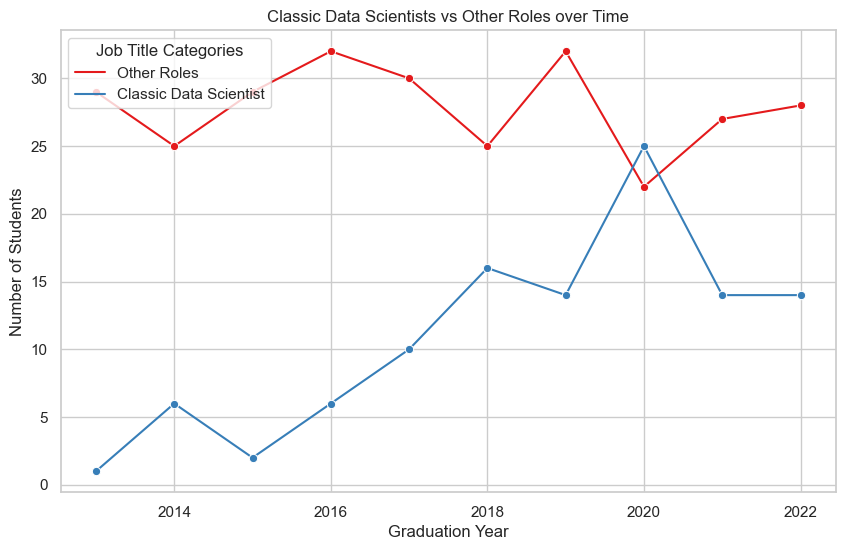

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a line plot using seaborn
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the line chart
sns.lineplot(data=q2, x="grad_year", y="student_count", hue="data_scientist", errorbar=None, marker='o', palette="Set1")

# Set plot labels and title
plt.xlabel("Graduation Year")
plt.ylabel("Number of Students")
plt.title("Classic Data Scientists vs Other Roles over Time")
plt.legend(title="Job Title Categories", loc='upper left')

# Show the plot
plt.show()

## Question 2 b Analyzing Names (Length of Name and has/has no Parentesis in it)

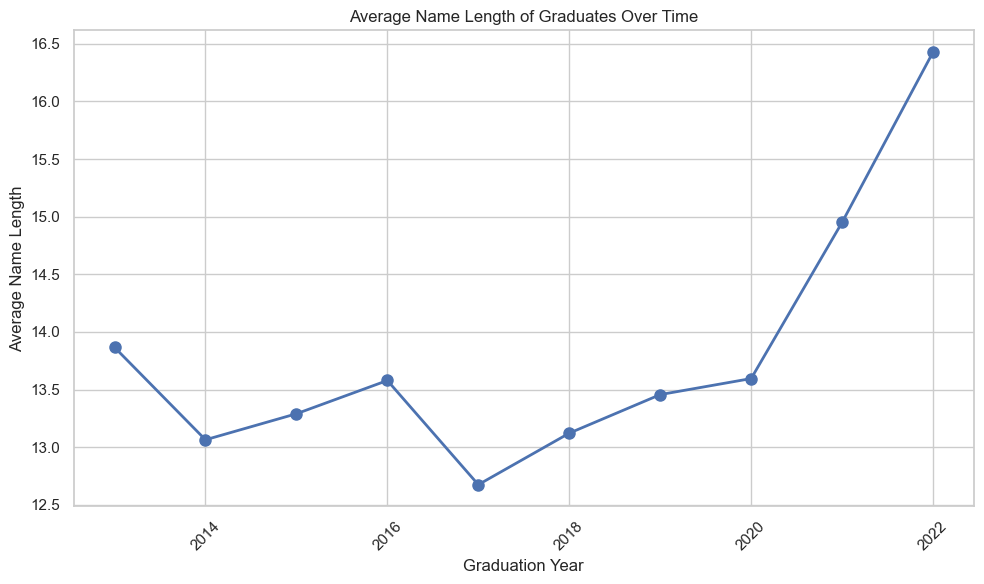

In [42]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with columns 'full_name' and 'grad_year'
data = final_df.copy()
# Calculate the length of names and add it as a new column 'name_length'
data['name_length'] = data['student_names'].apply(len)

# Group the data by graduation year and calculate the average name length for each year
average_name_length_by_year = data.groupby('grad_year')['name_length'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_name_length_by_year['grad_year'], average_name_length_by_year['name_length'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Graduation Year')
plt.ylabel('Average Name Length')
plt.title('Average Name Length of Graduates Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

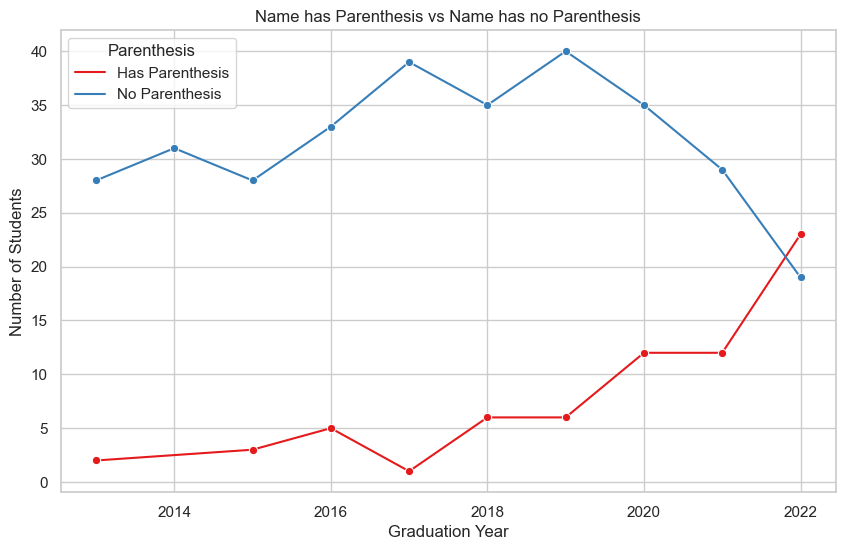

In [45]:
import matplotlib.pyplot as plt

data = final_df.copy()
data['has_parenthesis'] = np.where(data['student_names'].str.contains(r'\(.*\)', regex=True), 'Has Parenthesis', 'No Parenthesis')

# Group the data by graduation year and calculate the average name length for each year
data = data.groupby(['has_parenthesis','grad_year'])['student_names'].count().reset_index()
data.columns = ['has_parenthesis', 'grad_year','student_count']
#average_name_length_by_year = data.groupby('grad_year')['name_length'].mean().reset_index()

# Create a line plot using seaborn
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the line chart
sns.lineplot(data=data, x="grad_year", y="student_count", hue="has_parenthesis", errorbar=None, marker='o', palette="Set1")

# Set plot labels and title
plt.xlabel("Graduation Year")
plt.ylabel("Number of Students")
plt.title("Name has Parenthesis vs Name has no Parenthesis")
plt.legend(title="Parenthesis", loc='upper left')

# Show the plot
plt.show()

## B: API

In [13]:
import requests
from datetime import datetime, timedelta
import pandas as pd

# Replace 'YOUR_API_KEY' with your actual API key from World Weather Online
API_KEY = '87ea8345495942c9a72161238230711'

# Base URL for the World Weather Online API
BASE_URL = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx'

# List of 20 distinct locations for which you want to get historical temperature data
locations = ['New York', 'London', 'Paris', 'Tokyo', 'Sydney', 'Berlin', 'Beijing', 'Rio de Janeiro', 'Mumbai', 'Toronto',
             'Los Angeles', 'Chicago', 'Moscow', 'Dubai', 'Bangkok', 'Singapore', 'Seoul', 'Cairo', 'Rome', 'Madrid']

# Specify the start and end dates for the historical data (one month period)
start_date = datetime(2023, 10, 1)  # YYYY, MM, DD
end_date = datetime(2023, 10, 31)   # YYYY, MM, DD

# Format for the date in the API request
date_format = '%Y-%m-%d'

# Initialize an empty list to store the data
weather_data_list = []

# Loop through each location and date, fetch historical temperature data, and store it in the list
current_date = start_date
while current_date <= end_date:
    for location in locations:
        url = f'{BASE_URL}?key={API_KEY}&q={location}&date={current_date.strftime(date_format)}&format=json'
        response = requests.get(url)
        if response.status_code == 200:
            weather_data = response.json()
            max_temp = weather_data['data']['weather'][0]['maxtempC']
            min_temp = weather_data['data']['weather'][0]['mintempC']
            avg_temp = weather_data['data']['weather'][0]['avgtempC']
            # Append the data to the list
            weather_data_list.append({'Date': current_date.strftime(date_format), 'Location': location, 'Min Temperature (°C)': min_temp, 'Max Temperature (°C)': max_temp, 'Avg Temperature (°C)': avg_temp})
        else:
            print(f'Error fetching data for {location} on {current_date.strftime(date_format)}. Status code: {response.status_code}')
    current_date += timedelta(days=1)

# Create a DataFrame from the list of weather data
weather_df = pd.DataFrame(weather_data_list)

# Print the DataFrame
weather_df.head()

,Date,Location,Min Temperature (°C),Max Temperature (°C),Avg Temperature (°C)
0,2023-10-01,New York,14,24,18
1,2023-10-01,London,16,22,19
2,2023-10-01,Paris,15,27,21
3,2023-10-01,Tokyo,25,29,27
4,2023-10-01,Sydney,18,32,24


In [14]:
# Convert 'Min Temperature (°C)', 'Max Temperature (°C)', and 'Avg Temperature (°C)' columns to numeric
weather_df['Min Temperature (°C)'] = pd.to_numeric(weather_df['Min Temperature (°C)'], errors='coerce')
weather_df['Max Temperature (°C)'] = pd.to_numeric(weather_df['Max Temperature (°C)'], errors='coerce')
weather_df['Avg Temperature (°C)'] = pd.to_numeric(weather_df['Avg Temperature (°C)'], errors='coerce')

# Print the summary table
weather_df

,Date,Location,Min Temperature (°C),Max Temperature (°C),Avg Temperature (°C)
0,2023-10-01,New York,14,24,18
1,2023-10-01,London,16,22,19
2,2023-10-01,Paris,15,27,21
3,2023-10-01,Tokyo,25,29,27
4,2023-10-01,Sydney,18,32,24
...,...,...,...,...,...
615,2023-10-31,Singapore,27,30,28
616,2023-10-31,Seoul,12,21,16
617,2023-10-31,Cairo,22,32,26
618,2023-10-31,Rome,18,22,20


In [15]:
# Group the data by 'Location' and calculate min, mean, and max temperatures
summary_table = weather_df.groupby('Location').agg({
    'Min Temperature (°C)': 'min',
    'Max Temperature (°C)': 'max',
    'Avg Temperature (°C)': 'mean'
}).reset_index()

# Rename the columns for clarity
summary_table.rename(columns={
    'Min Temperature (°C)': 'Avg Min Temp (°C)',
    'Max Temperature (°C)': 'Avg Max Temp (°C)',
    'Avg Temperature (°C)': 'Avg Mean Temp (°C)'
}, inplace=True)

# Print the summary table
summary_table

,Location,Avg Min Temp (°C),Avg Max Temp (°C),Avg Mean Temp (°C)
0,Bangkok,25,34,28.129032
1,Beijing,10,27,17.838710
2,Berlin,5,27,12.677419
3,Cairo,20,34,25.806452
4,Chicago,-1,28,13.451613
5,Dubai,28,33,30.967742
6,London,7,24,14.032258
7,Los Angeles,13,38,21.709677
8,Madrid,9,32,18.806452
9,Moscow,-3,19,5.612903


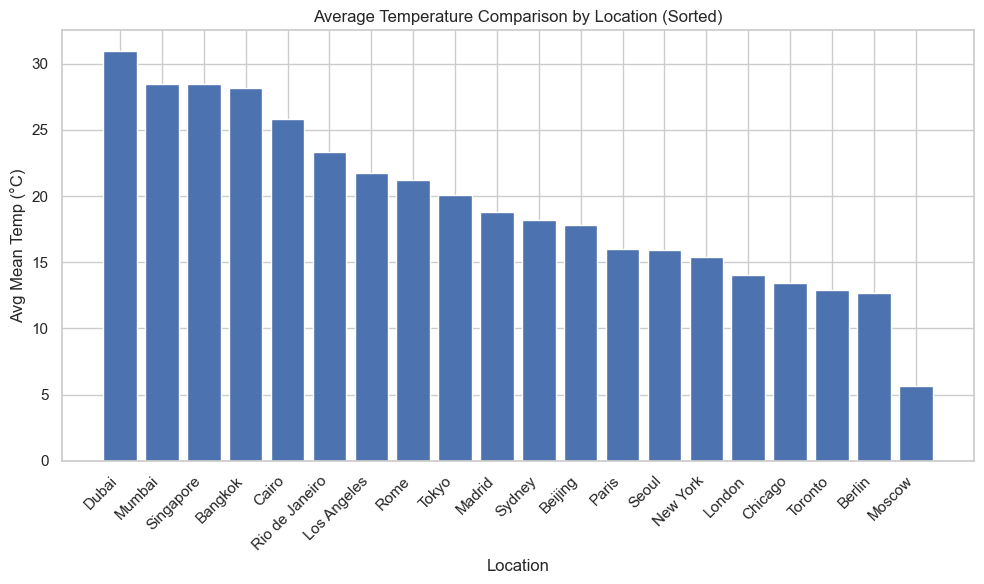

In [16]:
import matplotlib.pyplot as plt

# Sort the summary_table DataFrame by 'Avg Mean Temp (°C)'
summary_table_sorted = summary_table.sort_values(by='Avg Mean Temp (°C)', ascending=False)

# Plot average temperature for each location
plt.figure(figsize=(10, 6))
plt.bar(summary_table_sorted['Location'], summary_table_sorted['Avg Mean Temp (°C)'])

# Customize the plot
plt.xlabel('Location')
plt.ylabel('Avg Mean Temp (°C)')
plt.title('Average Temperature Comparison by Location (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Insides:
- Of all the major cities analyzed, Moscow is significantly more cold on average than the other cities. <br>
- Dubai is had the hottest mean temperature for the month of October 2023.